# MHD Code
#### 1D Warm-Up, Considering the Shock Tube Problem

#### The 1D System of Equations
$$ \frac{\partial}{\partial t}\mathbf{U} + \frac{\partial}{\partial x}\mathbf{f}(\mathbf{U}) = 0 $$
Where the conserved variables are $\mathbf{U}=\rho,\rho u_0, \rho u_1, \rho u_2, B_0, B_1, B_2, E$, with corresponding conservation equations written in terms of indexed conserved variables
$$ \begin{align*} f_0 &= U_1\\ f_1&=\frac{U_1^2}{U_0}-U_4^2+p+\frac{1}{2}\left( U_4^2+U_5^2+U_6^2 \right) \\ f_2 &= \frac{U_1U_2}{U_0}-U_4U_5 \\ f_3 &= \frac{U_1U_3}{U_1}-U_4U_6\\ f_4 &= 0 \\ f_5&= \frac{U_1U_5}{U_0}-\frac{U_4U_2}{U_0}\\ f_6&= \frac{U_1U_6}{U_0}-\frac{U_4U_3}{U_0}\\ f_7&= \frac{U_1}{U_0}\left( U_7 + p +\frac{1}{2}\left( U_4^2+U_5^2+U_6^2 \right) \right) - \frac{U_4}{U_0}(U_1U_4+U_2U_5+U_3U_6) \end{align*} $$

Looking closely may reveal an equation for $p$ would be helpful. In terms of the components of teh conserved variables, it is: $$p=(\gamma-1)\left( U_7-\frac{1}{2U_0}\left( U_1^2+U_2^2+U_3^2 \right) - \frac{1}{2}\left( U_4^2+u_5^2+U_6^2 \right) \right)$$

### The Model Problem
The Shock Tube Problem is given by the primitive variable ($\mathbf{W}=(\rho,u_0,u_1,u_2,B_0,B_1,B_2,p)^T$) states:
$$ \begin{align*} \mathbf{W}_L &= (3,0,0,0,3/2,3,1,0)^T\\ \mathbf{W}_R &= (1,0,0,0,0,1,\cos(1.5),\sin(1.5))^T \end{align*} $$ with $\gamma=5/3$, the adiabatic index. Consider zero-flux boundaries, on a regular grid of N cells partitioning the line $-1,1$.

#### Spacial Discretization
Using the Discontinuous Galerkin Formulation, on the partition of the line, the used discrete space is $$ V_h=V_h^k=\left\{ v:v\in P^k(I_j)\ \forall j \right\}$$ where $I_j$ is the cell $[x_{j-1/2},x_{j+1/2}]$. The integral form of the canonical equation leads to the semi-discrete in space DG formulation that reads: find $u_h\in V_h$ such that
$$ \frac{\partial}{\partial t} (u_h,v_h)_{I_j}-(f(u_h),\frac{\partial}{\partial x}v_h)_{I_j} + \tilde{f}_{j+1/2}v^-_{h,j+1/2} - \tilde{f}_{j-1/2}v^+_{h,j-1/2} = 0 $$ for all $v_h\in V^h$. $\tilde{f}(u^-,u^+)$ is the numerical flux, approximating the flux travelling between cells. The numerical flux demands some consideration into its choice. That is, it is required that $\tilde{f}(u,u)=\mathbf{f}(u)$, that is, the numerical flux is consistent. Additionally, $\tilde{f}$ must be Lipschitz continuous, and sometimes monotonic. 

For the sake of simplicity, (and implementation speed), taking $k=0$, meaning $v_h\to 1$, the semi-discrete form becomes
$$\boxed{ \frac{\partial}{\partial t}u_h = \frac{1}{|I_j|}\left( \tilde{f}_{j-1/2}-\tilde{f}_{j+1/2} \right) }$$
The Ideal MHD equations have seven different characteristic waves: 1 Entropy, 2 Alfven, 4 Magneto-acoustic -- 2 fast and 2 slow. This system is complicated, so for now some caution is reasonable. Instead of considering all 7 waves, approximate the solution between the fast magneto-acoustic waves with a single state. Eigen-analysis of $\mathbf{f}$ gives the eigenvalue assoiciated with the fast magneto-acoustic waves, $\lambda_f = u_0 \pm c_f$, where, using some foresight, defining $\alpha = \frac{\gamma p +\left( U_4^2+U_5^2+U_6^2 \right)}{U_0}$, makes the definition of $c_f$ slightly more compact:
$$ c_f = \sqrt{\frac{\alpha}{2}+\sqrt{\alpha^2-\frac{4\gamma p U_4^2}{U_0^2}}} $$

For the sake of nice notation, letting $u_1\pm c_f = \frac{U_1}{U_0}\pm c_f = a_{R,L}$, and considering $a^-=\min(a,0)$, $a^+=\max(a,0)$, the numerical flux can be defined:
$$\boxed{ \tilde{f}_{LR} = \frac{a_R^--a_L^-}{a_R-a_L}f_R+\frac{a_R^+-a_L^+}{a_R-a_L}f_L-\frac{1}{2}\frac{a_R|a_L|-a_L|a_R|}{a_R-a_L}(u_R-u_L) }$$
The very astute will notice $a_L$ and $a_R$ are yet to be computed. However, to maximize the chances of stability, taking $a_R = \max(U_1+c_f(U), \bar{U}_1+c_f(\bar{U})$, where the bar indicates the arithmetic average of $u_R$ and $u_L$ states, and $a_L = \min(U_1-c_f(U),\bar{U}_2-c_f(\bar{U}))$, the numerical flux function can be evaluated.

#### Temporal Discretization
Now that a semi-discrete formulation is complete, an explicity RK-type time-stepping scheme can be used to integrate the equation in time.

In [29]:
### Imports
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import backend as bk

### Parameters
gamma = 2
N = 400
l = 1

### Spatial Discretization
h = 1/N
msh = bk.Mesh((-l-h,l+h),N+2)
BCidx = [0, -1]
BCvalsidx = [1, -2]

### Numerical Flux Shenanigans
 # Analytical Flux
def flux(U):
    f0 = U[1]
    f1 = U[1]**2/U[0] - U[4]**2 + bk.p(U) + 0.5*(U[4]**2+U[5]**2+U[6]**2)
    f2 = U[1]*U[2]/U[0] - U[4]*U[5]
    f3 = U[1]*U[3]/U[0] - U[4]*U[6]
    f4 = 0
    f5 = U[1]*U[5]/U[0] - U[4]*U[2]/U[0]
    f6 = U[1]*U[6]/U[0] - U[4]*U[3]/U[0]
    f7 = U[1]/U[0] * (U[7] + bk.p(U,gamma) + 0.5*(U[4]**2+U[5]**2+U[6]**2)
                     ) - U[4]*(U[1]*U[4]+U[2]*U[5]+U[3]*U[6])/U[0]
    return np.array([f0, f1, f2, f3, f4, f5, f6, f7])

 # Numerical Flux
def ftilde(UL,UR):
    Ubar = 0.5*(UL+UR)
    aL = min(Ubar[1] - bk.cf(Ubar, gamma), UL[1] - bk.cf(UL, gamma))
    aR = max(Ubar[1] + bk.cf(Ubar, gamma), UR[1] + bk.cf(UR, gamma))
    
    aRm = min(aR,0)
    aRp = max(aR,0)
    aLm = min(aL,0)
    aLp = max(aL,0)
    
    return (aRm-aLm)/(aR-aL)*flux(UR)+(aRp-aLp)/(aR-aL)*flux(UL)-0.5*(aR*abs(aL)-aL*abs(aR))/(aR-aL)*(UR-UL)

 # Semi-Discrete Formulation
def F(j): # for j in [1,N+1]
    lm = j-1
    lp = j
    rm = j
    rp = j+1
    return (ftilde(msh.sln.U[lm],msh.sln.U[lp]) - ftilde(msh.sln.U[rm],msh.sln.U[rp])) / msh.spans[j]

In [30]:
### Temporal Discretization
# Timing Parameters
dt = h/10
T = 0.2

# Initial Condition
Wl = [1,0,0,0,0.75,1,0,1]
Wr = [0.125,0,0,0,0.75,-1,0,0.1]
def u0(x):
    if x <= 0:
        return bk.consv(Wl, gamma)
    return bk.consv(Wr, gamma)
msh.sln.set_u(u0)

 # First forward euler time-step
for j in range(1,N+1):
    msh.sln.F0[j] = F(j)
    msh.sln.U[j] = bk.fe(msh.sln.U[j],msh.sln.F0[j],dt)
msh.sln.impose_BC(BCidx, msh.sln.U[BCvalsidx])

# Time-stepping with AB2
t = dt
while t < T:
    clear_output(wait=True)
    t += dt
    for j in range(1,N+1):
        msh.sln.F1[j] = F(j)
        u1 = bk.ab2(msh.sln.U[j],msh.sln.F1[j],msh.sln.F0[j],dt)
        msh.sln.F0[j] = msh.sln.F1[j]
        msh.sln.U[j] = u1
    msh.sln.impose_BC(BCidx, msh.sln.U[BCvalsidx])
    
    # determine largest possible timestep
    cfmax = max([bk.cf(U, gamma) for U in msh.sln.U])
    dt = min(h/(2*cfmax), h/10)


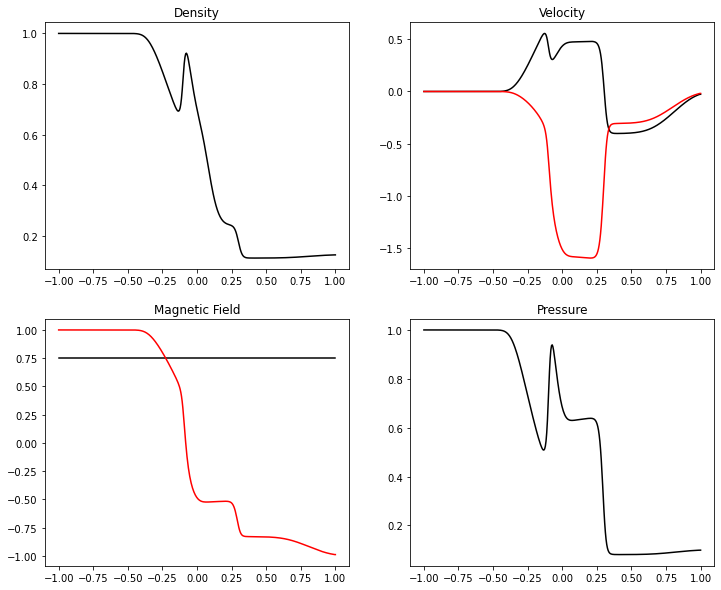

In [32]:
# Plotting Result
msh.sln.get_prim(gamma)
rho = msh.sln.W[:,0]
v = msh.sln.W[:,1:3]
B = msh.sln.W[:,4:6]
p = msh.sln.W[:,7]

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(221)
ax.plot(msh.x0,rho,'-k')
ax.title.set_text('Density')
ax = fig.add_subplot(222)
ax.plot(msh.x0,v[:,0],'-k')
ax.plot(msh.x0,v[:,1],'-r')
ax.title.set_text('Velocity')
ax = fig.add_subplot(223)
ax.plot(msh.x0,B[:,0],'-k')
ax.plot(msh.x0,B[:,1],'-r')
ax.title.set_text('Magnetic Field')
ax = fig.add_subplot(224)
ax.plot(msh.x0,p,'-k')
ax.title.set_text('Pressure')
plt.show()